In [1]:
# Importing Necessary Libraries
import os
os.environ['TF_ENABLE_ONEDNN_OPTS'] = "0"
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from keras import layers
from keras import regularizers
from tensorflow.keras.utils import register_keras_serializable
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, LSTM, Reshape, GRU, BatchNormalization, Softmax, Permute, Multiply, Lambda, RepeatVector
import tensorflow.keras.backend as K


In [2]:
# Mounting drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# Importing helper function files
import sys
sys.path.append('/content/drive/MyDrive/CS 230 Project')
from utilLoss import *

In [4]:
# Loading the model to calculate the response spectrum
responseModel = keras.models.load_model("/content/drive/MyDrive/CS 230 Project/responseModel.keras")
responseModel.trainable=False

In [5]:
#Custom loss model
@register_keras_serializable()
def responseLoss(y,yhat):
    #MSE of predicted response spectra
    ySpectrum=responseModel(y)
    yhatSpectrum=responseModel(yhat)
    spectrumLoss=tf.divide(tf.reduce_mean(tf.square(tf.subtract(ySpectrum,yhatSpectrum))),tf.reduce_mean(tf.square(ySpectrum)))

    #Relative difference in Arias intensities
    aly=tf.reduce_sum(tf.square(y))
    alyhat=tf.reduce_sum(tf.square(yhat))
    ariasLoss=tf.divide(tf.abs(tf.subtract(aly,alyhat)),aly)

    #Direct MSE comparison of records, normalized
    motionLoss=tf.divide(tf.reduce_mean(tf.square(tf.subtract(y,yhat))),tf.reduce_mean(tf.square(y)))

    #Equally weight normalized losses
    return tf.divide(tf.add(spectrumLoss,tf.add(ariasLoss,motionLoss)),3.0)

In [6]:
# Loading the Preprocessed Data
tf.compat.v1.enable_eager_execution()
xfilepath="/content/drive/MyDrive/CS 230 Project/4096_dataset/inputExpanded.csv"
ypath="/content/drive/MyDrive/CS 230 Project/4096_dataset/output.npy"

input_data= pd.read_csv(xfilepath)
x= input_data.to_numpy()
y=np.load(ypath)

#Shuffle and split data into Train and Test Sets
m=x.shape[0]
testSplit=0.05
shuffle=np.arange(m)
np.random.shuffle(shuffle)
x=x[shuffle,:]
y=y[shuffle,:]
index=int(np.floor(m*(1-testSplit)))
xTrain=x[0:index,:]
yTrain=y[0:index,:]
xTest=x[index:,:]
yTest=y[index:,:]

In [7]:
print(x.shape, y.shape, xTrain.shape, yTrain.shape, xTest.shape, yTest.shape)

(53959, 93) (53959, 4096) (51261, 93) (51261, 4096) (2698, 93) (2698, 4096)


In [ ]:
# Model Desc: 1 Dense + 2 LSTM Layers + MSE Error -- Baseline

# Constants
INPUT_FEATURES = xTrain.shape[1]       # Number of input features
SEQUENCE_LENGTH = yTrain.shape[1]      # Length of the output sequence
HIDDEN_UNITS_1 = 1024        # LSTM layer 1 units
HIDDEN_UNITS_2 = 1024        # LSTM layer 2 units
DENSE_UNITS = 1024          # Dense layer units

# Model Definition
def build_model(input_features, sequence_length, dense_units, hidden_units_1, hidden_units_2):
    # Input Layer
    input_layer = Input(shape=(input_features,))

    # Dense Layer
    dense = Dense(dense_units, activation='relu')(input_layer)

    # Reshape Layer (to prepare for LSTM input)
    reshape = Reshape((1, dense_units))(dense)

    # LSTM Layers
    lstm_1 = LSTM(hidden_units_1, return_sequences=True)(reshape)
    lstm_2 = LSTM(hidden_units_2, return_sequences=True)(lstm_1)

    # Output Layer (Dense with linear activation)
    output_layer = Dense(sequence_length, activation='linear')(lstm_2)

    # Create Model
    model = Model(inputs=input_layer, outputs=output_layer)
    model.compile(optimizer='adam', loss='mse')
    return model

# Build and compile the model
model = build_model(INPUT_FEATURES, SEQUENCE_LENGTH, DENSE_UNITS, HIDDEN_UNITS_1, HIDDEN_UNITS_2)

# Summary of the model
model.summary()
# Train the model
model.fit(xTrain, yTrain, epochs=1, batch_size=1024, validation_split=0.1)
# Save the model
model.save('/content/drive/MyDrive/CS 230 Project/lstm_model_1')

# Load the model
from tensorflow.keras.models import load_model
loaded_model = load_model('/content/drive/MyDrive/CS 230 Project/lstm_model_1')

# Retrain the loaded model

history = loaded_model.fit(xTrain, yTrain, epochs=10, batch_size=1024, validation_split=0.1)

# Plot training & validation loss values
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Save the model
model.save('/content/drive/MyDrive/CS 230 Project/lstm_model_1')

In [ ]:
# Model Desc: 1 Dense + 2 LSTM Layers + MSE Error + LR = 0.01

# Constants
INPUT_FEATURES = xTrain.shape[1]       # Number of input features
SEQUENCE_LENGTH = yTrain.shape[1]      # Length of the output sequence
HIDDEN_UNITS_1 = 1024        # LSTM layer 1 units
HIDDEN_UNITS_2 = 1024        # LSTM layer 2 units
DENSE_UNITS = 1024          # Dense layer units

# Model Definition
def build_model(input_features, sequence_length, dense_units, hidden_units_1, hidden_units_2):
    # Input Layer
    input_layer = Input(shape=(input_features,))

    # Dense Layer
    dense = Dense(dense_units, activation='relu')(input_layer)

    # Reshape Layer (to prepare for LSTM input)
    reshape = Reshape((1, dense_units))(dense)

    # LSTM Layers
    lstm_1 = LSTM(hidden_units_1, return_sequences=True)(reshape)
    lstm_2 = LSTM(hidden_units_2, return_sequences=True)(lstm_1)

    # Output Layer (Dense with linear activation)
    output_layer = Dense(sequence_length, activation='linear')(lstm_2)

    # Create Model
    model = Model(inputs=input_layer, outputs=output_layer)
    optimizer = keras.optimizers.Adam(learning_rate=0.01)
    model.compile(optimizer=optimizer, loss='mse')
    return model

# Build and compile the model
model_lrplus = build_model(INPUT_FEATURES, SEQUENCE_LENGTH, DENSE_UNITS, HIDDEN_UNITS_1, HIDDEN_UNITS_2)

# Summary of the model
model_lrplus.summary()
# Train the model
model_lrplus.fit(xTrain, yTrain, epochs=5, batch_size=64, validation_split=0.1)

In [ ]:
# Model Desc: 1 Dense + 2 LSTM Layers + MSE Error + LR = 0.0001

# Constants
INPUT_FEATURES = xTrain.shape[1]       # Number of input features
SEQUENCE_LENGTH = yTrain.shape[1]      # Length of the output sequence
HIDDEN_UNITS_1 = 1024        # LSTM layer 1 units
HIDDEN_UNITS_2 = 1024        # LSTM layer 2 units
DENSE_UNITS = 1024          # Dense layer units

# Model Definition
def build_model(input_features, sequence_length, dense_units, hidden_units_1, hidden_units_2):
    # Input Layer
    input_layer = Input(shape=(input_features,))

    # Dense Layer
    dense = Dense(dense_units, activation='relu')(input_layer)

    # Reshape Layer (to prepare for LSTM input)
    reshape = Reshape((1, dense_units))(dense)

    # LSTM Layers
    lstm_1 = LSTM(hidden_units_1, return_sequences=True)(reshape)
    lstm_2 = LSTM(hidden_units_2, return_sequences=True)(lstm_1)

    # Output Layer (Dense with linear activation)
    output_layer = Dense(sequence_length, activation='linear')(lstm_2)

    # Create Model
    model = Model(inputs=input_layer, outputs=output_layer)
    optimizer = keras.optimizers.Adam(learning_rate=0.0001)
    model.compile(optimizer=optimizer, loss='mse')
    return model

# Build and compile the model
model_lrminus = build_model(INPUT_FEATURES, SEQUENCE_LENGTH, DENSE_UNITS, HIDDEN_UNITS_1, HIDDEN_UNITS_2)

# Summary of the model
model_lrminus.summary()
# Train the model
history_minus = model_lrminus.fit(xTrain, yTrain, epochs=5, batch_size=64, validation_split=0.1)
# Save the model
model_lrminus.save('/content/drive/MyDrive/Colab Notebooks/rnn_model_1024_lrminus.keras')

In [ ]:
# Model Desc: 2 Dense + 2 LSTM Layers + MSE Error + LR = 0.0001 (Extra Dense Layer)
# Constants
INPUT_FEATURES = xTrain.shape[1]       # Number of input features
SEQUENCE_LENGTH = yTrain.shape[1]      # Length of the output sequence
HIDDEN_UNITS_1 = 1024        # LSTM layer 1 units
HIDDEN_UNITS_2 = 1024        # LSTM layer 2 units
DENSE_UNITS = 1024          # Dense layer units

# Model Definition
def build_model(input_features, sequence_length, dense_units, hidden_units_1, hidden_units_2):
    # Input Layer
    input_layer = Input(shape=(input_features,))

    # Dense Layer
    dense = Dense(dense_units, activation='relu')(input_layer)

    # Reshape Layer (to prepare for LSTM input)
    reshape = Reshape((1, dense_units))(dense)

    # LSTM Layers
    lstm_1 = LSTM(hidden_units_1, return_sequences=True)(reshape)
    lstm_2 = LSTM(hidden_units_2, return_sequences=True)(lstm_1)

    # Output Layer (Dense with linear activation)
    output_layer = Dense(sequence_length, activation='linear')(lstm_2)

    # Create Model
    model = Model(inputs=input_layer, outputs=output_layer)
    optimizer = keras.optimizers.Adam(learning_rate=0.0001)
    model.compile(optimizer=optimizer, loss='mse')
    return model

# Build and compile the model
model = build_model(INPUT_FEATURES, SEQUENCE_LENGTH, DENSE_UNITS, HIDDEN_UNITS_1, HIDDEN_UNITS_2)

# Summary of the model
model.summary()
# Train the model
model.fit(xTrain, yTrain, epochs=1, batch_size=64, validation_split=0.1)
# Save the model
model.save('/content/drive/MyDrive/CS 230 Project/lstm_model_2')

# Load the model
from tensorflow.keras.models import load_model
loaded_model = load_model('/content/drive/MyDrive/CS 230 Project/lstm_model_2')

# Retrain the loaded model
loaded_model.fit(xTrain, yTrain, epochs=10, batch_size=64, validation_split=0.1)
# Save the model
model.save('/content/drive/MyDrive/CS 230 Project/lstm_model_2')

In [ ]:
# Model Desc: 2 Dense + 2 LSTM Layers + + LR = 0.0001 +  Response Loss -- Custom Loss Function
# Constants
INPUT_FEATURES = xTrain.shape[1]       # Number of input features
SEQUENCE_LENGTH = yTrain.shape[1]      # Length of the output sequence
HIDDEN_UNITS_1 = 1024        # LSTM layer 1 units
HIDDEN_UNITS_2 = 1024        # LSTM layer 2 units
DENSE_UNITS = 1024          # Dense layer units
DENSE_UNITS_1 = 256         # Extra Dense layer units

# Model Definition
def build_model(input_features, sequence_length, extradense_units, dense_units, hidden_units_1, hidden_units_2):
    # Input Layer
    input_layer = Input(shape=(input_features,))

    # Dense Layer
    dense = Dense(extradense_units, activation='relu')(input_layer)
    dense = Dense(dense_units, activation='relu')(dense)

    # Reshape Layer (to prepare for LSTM input)
    reshape = Reshape((1, dense_units))(dense)

    # LSTM Layers
    lstm_1 = LSTM(hidden_units_1, return_sequences=True)(reshape)
    lstm_2 = LSTM(hidden_units_2, return_sequences=True)(lstm_1)

    # Output Layer (Dense with linear activation)
    output_layer = Dense(sequence_length, activation='linear')(lstm_2)

    # Create Model
    model = Model(inputs=input_layer, outputs=output_layer)
    optimizer = keras.optimizers.Adam(learning_rate=0.0001)
    model.compile(optimizer=optimizer, loss=responseLoss, metrics=[responseLoss])
    return model

# Build and compile the model
model_extradense = build_model(INPUT_FEATURES, SEQUENCE_LENGTH,DENSE_UNITS_1, DENSE_UNITS, HIDDEN_UNITS_1, HIDDEN_UNITS_2)

# Summary of the model
model_extradense.summary()


Model: "functional_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 93)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 256)                 │          24,064 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1024)                │         263,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ reshape (Reshape)                    │ (None, 1, 1024)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm (LSTM)                          │ (None, 1, 1024)             │       8,392,704 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 1, 1024)             │       8,392,704 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 1, 4096)             │       4,198,400 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 21,271,040 (81.14 MB)

 Trainable params: 21,271,040 (81.14 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Train the model
history_minus = model_extradense.fit(xTrain, yTrain, epochs=1, batch_size=64, validation_split=0.1)

721/721 ━━━━━━━━━━━━━━━━━━━━ 1370s 2s/step - loss: 0.9397 - response_loss: 0.9397 - val_loss: 0.8170 - val_response_loss: 0.8162


In [ ]:
# Save the model
model_extradense.save('/content/drive/MyDrive/CS 230 Project/rnn_model_1024_extradense_response_loss.keras')

In [ ]:
# Model Desc: 2 Dense + 2 LSTM Layers + Response Loss + Learning Rate = 0.0001 + Batch Normalization --- Final Model
def build_model(input_features, sequence_length, extradense_units, dense_units, hidden_units_1, hidden_units_2):
    # Input Layer
    input_layer = Input(shape=(input_features,))

    # Dense Layer + Batch Normalization
    dense = Dense(extradense_units, activation='relu')(input_layer)
    dense = BatchNormalization()(dense)  # Batch Normalization after first Dense
    dense = Dense(dense_units, activation='relu')(dense)
    dense = BatchNormalization()(dense)  # Batch Normalization after second Dense

    # Reshape Layer (to prepare for LSTM input)
    reshape = Reshape((1, dense_units))(dense)

    # LSTM Layers
    lstm_1 = LSTM(hidden_units_1, return_sequences=True)(reshape)
    lstm_2 = LSTM(hidden_units_2, return_sequences=True)(lstm_1)

    # Output Layer (Dense with linear activation)
    output_layer = Dense(sequence_length, activation='linear')(lstm_2)

    # Create Model
    model = Model(inputs=input_layer, outputs=output_layer)
    optimizer = keras.optimizers.Adam(learning_rate=0.0001)

    # Compile the model with custom loss function
    model.compile(optimizer=optimizer, loss=responseLoss, metrics=[responseLoss])

    return model
model_1024_batch_norm=build_model(INPUT_FEATURES, SEQUENCE_LENGTH,DENSE_UNITS_1, DENSE_UNITS, HIDDEN_UNITS_1, HIDDEN_UNITS_2)

# Summary of the model
model_1024_batch_norm.summary()

Model: "functional_11"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, 93)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 256)                 │          24,064 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 256)                 │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 1024)                │         263,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 1024)                │           4,096 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ reshape_1 (Reshape)                  │ (None, 1, 1024)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_2 (LSTM)                        │ (None, 1, 1024)             │       8,392,704 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_3 (LSTM)                        │ (None, 1, 1024)             │       8,392,704 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 1, 4096)             │       4,198,400 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 21,276,160 (81.16 MB)

 Trainable params: 21,273,600 (81.15 MB)

 Non-trainable params: 2,560 (10.00 KB)

In [ ]:
# Train the model
history_1024_batch_norm = model_1024_batch_norm.fit(xTrain, yTrain, epochs=1, batch_size=64, validation_split=0.1)

721/721 ━━━━━━━━━━━━━━━━━━━━ 1362s 2s/step - loss: 0.8392 - response_loss: 0.8392 - val_loss: 0.8040 - val_response_loss: 0.8033


In [ ]:
# Save the model
model_1024_batch_norm.save('/content/drive/MyDrive/CS 230 Project/rnn_model_1024_batchnorm_response_loss.keras')

In [ ]:
# Load and retrain the model
model_1024_batch_norm = keras.models.load_model("/content/drive/MyDrive/CS 230 Project/rnn_model_1024_batchnorm_response_loss.keras", custom_objects={'responseLoss': responseLoss})
history_1024_batch_norm = model_1024_batch_norm.fit(xTrain, yTrain, epochs=2, batch_size=32, validation_split=0.1)


Epoch 1/2
1442/1442 ━━━━━━━━━━━━━━━━━━━━ 1414s 977ms/step - loss: 0.8312 - response_loss: 0.8312 - val_loss: 0.8274 - val_response_loss: 0.8279
Epoch 2/2
1442/1442 ━━━━━━━━━━━━━━━━━━━━ 1451s 970ms/step - loss: 0.8074 - response_loss: 0.8074 - val_loss: 0.8027 - val_response_loss: 0.8034


In [ ]:
model_1024_batch_norm.save('/content/drive/MyDrive/CS 230 Project/rnn_model_1024_batchnorm_response_loss.keras')

In [ ]:
# Plot to compare the generated and actual sequence
%matplotlib inline

# Number of examples to plot
num_examples = 8

# Create a figure and subplots
fig, axes = plt.subplots(num_examples, 2, figsize=(12, 4 * num_examples))

# Iterate through the examples
for i in range(num_examples):
    # Select a random example from the test set
    example_index = np.random.randint(0, len(xTest))
    test_input = np.reshape(xTest[example_index, :], (1, 93))
    generated_sequence = model_1024_batch_norm.predict(test_input)

    # Plot the generated sequence
    axes[i, 0].plot(generated_sequence[0, 0, :], label='Generated Sequence', marker='o')
    axes[i, 0].set_title(f"Generated Sequence (Example {i+1})")
    axes[i, 0].set_xlabel("Time Step")
    axes[i, 0].set_ylabel("Value")
    axes[i, 0].legend()

    # Plot the true sequence
    axes[i, 1].plot(yTest[example_index, :], label='True Sequence', marker='x')
    axes[i, 1].set_title(f"True Sequence (Example {i+1})")
    axes[i, 1].set_xlabel("Time Step")
    axes[i, 1].set_ylabel("Value")
    axes[i, 1].legend()

# Adjust spacing between subplots
plt.tight_layout()
plt.show()

In [ ]:
# Model Desc: 2 Dense + 2 GRU Layers + Response Loss + Learning Rate = 0.0001 + Batch Normalization

def build_model(input_features, sequence_length, extradense_units, dense_units, hidden_units_1, hidden_units_2):
    # Input Layer
    input_layer = Input(shape=(input_features,))


    # Dense Layer + Batch Normalization
    dense = Dense(extradense_units, activation='relu')(input_layer)
    dense = BatchNormalization()(dense)  # Batch Normalization after the first Dense
    dense = Dense(dense_units, activation='relu')(dense)
    dense = BatchNormalization()(dense)  # Batch Normalization after the second Dense

    # Reshape Layer (to prepare for GRU input)
    reshape = Reshape((1, dense_units))(dense)

    # GRU Layers
    gru_1 = GRU(hidden_units_1, return_sequences=True)(reshape)
    gru_2 = GRU(hidden_units_2, return_sequences=True)(gru_1)

    # Output Layer (Dense with linear activation)
    output_layer = Dense(sequence_length, activation='linear')(gru_2)

    # Create Model
    model = Model(inputs=input_layer, outputs=output_layer)
    optimizer = keras.optimizers.Adam(learning_rate=0.0001)

    # Compile the model with custom loss function
    model.compile(optimizer=optimizer, loss=responseLoss, metrics=[responseLoss])

    return model

model_1024_batch_norm_gru=build_model(INPUT_FEATURES, SEQUENCE_LENGTH,DENSE_UNITS_1, DENSE_UNITS, HIDDEN_UNITS_1, HIDDEN_UNITS_2)

# Summary of the model
model_1024_batch_norm_gru.summary()

Model: "functional_14"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_4 (InputLayer)           │ (None, 93)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_12 (Dense)                     │ (None, 256)                 │          24,064 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_6                │ (None, 256)                 │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_13 (Dense)                     │ (None, 1024)                │         263,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_7                │ (None, 1024)                │           4,096 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ reshape_4 (Reshape)                  │ (None, 1, 1024)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ gru_4 (GRU)                          │ (None, 1, 1024)             │       6,297,600 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ gru_5 (GRU)                          │ (None, 1, 1024)             │       6,297,600 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_14 (Dense)                     │ (None, 1, 4096)             │       4,198,400 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 17,085,952 (65.18 MB)

 Trainable params: 17,083,392 (65.17 MB)

 Non-trainable params: 2,560 (10.00 KB)

In [ ]:
# Train the model
history_1024_batch_norm = model_1024_batch_norm_gru.fit(xTrain, yTrain, epochs=1, batch_size=32, validation_split=0.1)

In [ ]:
# Save the model
model_1024_batch_norm_gru.save('/content/drive/MyDrive/CS 230 Project/rnn_model_1024_batchnorm_response_loss_gru.keras')

In [11]:
# Constants
INPUT_FEATURES = xTrain.shape[1]       # Number of input features
SEQUENCE_LENGTH = yTrain.shape[1]      # Length of the output sequence
HIDDEN_UNITS_1 = 1024        # LSTM layer 1 units
HIDDEN_UNITS_2 = 1024        # LSTM layer 2 units
DENSE_UNITS_1 = 256          # extra Dense layer units
DENSE_UNITS = 1024          # Dense layer units


# Model Definition
def build_model(input_features, sequence_length, xdense_units, dense_units, hidden_units_1, hidden_units_2):
    # Input Layer
    input_layer = Input(shape=(input_features,))

    # Dense Layer
    dense = Dense(xdense_units, activation='relu')(input_layer)
    dense = Dense(dense_units, activation='relu')(dense)

    # Reshape Layer (to prepare for LSTM input)
    reshape = Reshape((1, dense_units))(dense)

    # LSTM Layer 1
    lstm_1 = LSTM(hidden_units_1, return_sequences=True)(reshape)

    # Attention Mechanism
    attention_scores = Dense(hidden_units_1, activation='tanh')(lstm_1)  # Scores shape: (batch_size, hidden_units, 1)
    attention_scores = Reshape((hidden_units_1,))(attention_scores)  # Reshape to (batch_size, hidden_units)
    attention_weights = Softmax(axis=1)(attention_scores)  # Normalize scores (batch_size, hidden_units)

    # Compute attention-weighted output
    attention_weights = RepeatVector(hidden_units_1)(attention_weights)  # (batch_size, hidden_units_1, 1)
    attention_weights = Permute([2, 1])(attention_weights)  # (batch_size, 1, hidden_units_1)
    context_vector = Multiply()([lstm_1, attention_weights])  # Element-wise multiplication
    context_vector = Lambda(lambda x: K.sum(x, axis=1))(context_vector)  # Sum over time_steps

    # LSTM Layer 2
    lstm_2 = LSTM(hidden_units_2, return_sequences=True)(Reshape((1, hidden_units_1))(context_vector))

    # Output Layer (Dense with linear activation)
    output_layer = Dense(sequence_length, activation='linear')(lstm_2)

    # Create Model
    model = Model(inputs=input_layer, outputs=output_layer)
    optimizer = keras.optimizers.Adam(learning_rate=0.0001)
    model.compile(optimizer=optimizer, loss=responseLoss)
    return model

# Build and compile the model
model_attention = build_model(INPUT_FEATURES, SEQUENCE_LENGTH, DENSE_UNITS_1, DENSE_UNITS, HIDDEN_UNITS_1, HIDDEN_UNITS_2)

# Summary of the model
model_attention.summary()


Model: "functional_12"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2             │ (None, 93)             │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_8 (Dense)           │ (None, 256)            │         24,064 │ input_layer_2[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_9 (Dense)           │ (None, 1024)           │        263,168 │ dense_8[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ reshape_6 (Reshape)       │ (None, 1, 1024)        │              0 │ dense_9[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lstm_4 (LSTM)             │ (None, 1, 1024)        │      8,392,704 │ reshape_6[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_10 (Dense)          │ (None, 1, 1024)        │      1,049,600 │ lstm_4[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ reshape_7 (Reshape)       │ (None, 1024)           │              0 │ dense_10[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ softmax_2 (Softmax)       │ (None, 1024)           │              0 │ reshape_7[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ repeat_vector_2           │ (None, 1024, 1024)     │              0 │ softmax_2[0][0]        │
│ (RepeatVector)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ permute_2 (Permute)       │ (None, 1024, 1024)     │              0 │ repeat_vector_2[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ multiply_2 (Multiply)     │ (None, 1024, 1024)     │              0 │ lstm_4[0][0],          │
│                           │                        │                │ permute_2[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lambda_2 (Lambda)         │ (None, 1024)           │              0 │ multiply_2[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ reshape_8 (Reshape)       │ (None, 1, 1024)        │              0 │ lambda_2[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lstm_5 (LSTM)             │ (None, 1, 1024)        │      8,392,704 │ reshape_8[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_11 (Dense)          │ (None, 1, 4096)        │      4,198,400 │ lstm_5[0][0]           │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 22,320,640 (85.15 MB)

 Trainable params: 22,320,640 (85.15 MB)

 Non-trainable params: 0 (0.00 B)

In [12]:
# Train the model
history_attention_model = model_attention.fit(xTrain, yTrain, epochs=1, batch_size=32, validation_split=0.1)
# Save the model
model_attention.save('/content/drive/MyDrive/CS 230 Project/attention_model.keras')

1442/1442 ━━━━━━━━━━━━━━━━━━━━ 67s 44ms/step - loss: 0.9391 - val_loss: 0.8146


In [15]:
# Load and retrain the model
history_attention_model = model_attention.fit(xTrain, yTrain, epochs=20, batch_size=32, validation_split=0.1)


Epoch 1/20
1442/1442 ━━━━━━━━━━━━━━━━━━━━ 63s 44ms/step - loss: 0.8355 - val_loss: 0.8147
Epoch 2/20
1442/1442 ━━━━━━━━━━━━━━━━━━━━ 63s 44ms/step - loss: 0.8239 - val_loss: 0.8088
Epoch 3/20
1442/1442 ━━━━━━━━━━━━━━━━━━━━ 65s 45ms/step - loss: 0.8151 - val_loss: 0.8066
Epoch 4/20
1442/1442 ━━━━━━━━━━━━━━━━━━━━ 62s 43ms/step - loss: 0.8096 - val_loss: 0.8052
Epoch 5/20
1442/1442 ━━━━━━━━━━━━━━━━━━━━ 64s 44ms/step - loss: 0.8090 - val_loss: 0.8034
Epoch 6/20
1442/1442 ━━━━━━━━━━━━━━━━━━━━ 80s 43ms/step - loss: 0.7995 - val_loss: 0.7976
Epoch 7/20
1442/1442 ━━━━━━━━━━━━━━━━━━━━ 82s 43ms/step - loss: 0.7987 - val_loss: 0.7978
Epoch 8/20
1442/1442 ━━━━━━━━━━━━━━━━━━━━ 83s 44ms/step - loss: 0.7930 - val_loss: 0.7910
Epoch 9/20
1442/1442 ━━━━━━━━━━━━━━━━━━━━ 83s 44ms/step - loss: 0.7927 - val_loss: 0.8023
Epoch 10/20
1442/1442 ━━━━━━━━━━━━━━━━━━━━ 82s 45ms/step - loss: 0.7916 - val_loss: 0.7915
Epoch 11/20
1442/1442 ━━━━━━━━━━━━━━━━━━━━ 65s 45ms/step - loss: 0.7923 - val_loss: 0.7972
Epoch 12

In [16]:
# Save the model
model_attention.save('/content/drive/MyDrive/CS 230 Project/attention_model.keras')

In [17]:
@register_keras_serializable()
def spectrum(y,yhat):
    ySpectrum=responseModel(y)
    yhatSpectrum=responseModel(yhat)
    return tf.divide(tf.divide(tf.reduce_mean(tf.square(tf.subtract(ySpectrum,yhatSpectrum))),tf.reduce_mean(tf.square(ySpectrum))+1e-8),0.01)

#Non-tensorflow version of the above
def spectrumNP(y,yhat):
    ySpectrum=responseModel(y)
    yhatSpectrum=responseModel(yhat)
    return np.mean(np.abs(ySpectrum-yhatSpectrum)/ySpectrum,axis=1)

#Normalized MSE of predicted response spectra
@register_keras_serializable()
def spectrumNormalized(y,yhat):
    ySpectrum=responseModel(y)
    ySpectrum=tf.divide(ySpectrum,tf.reduce_mean(ySpectrum,axis=1,keepdims=True))
    yhatSpectrum=responseModel(yhat)
    yhatSpectrum=tf.divide(yhatSpectrum,tf.reduce_mean(yhatSpectrum,axis=1,keepdims=True))
    return tf.reduce_mean(tf.square(tf.subtract(ySpectrum,yhatSpectrum)))

#Relative difference in Arias intensities
@register_keras_serializable()
def arias(y,yhat):
    aly=tf.reduce_sum(tf.square(y))
    alyhat=tf.reduce_sum(tf.square(yhat))
    return tf.divide(tf.abs(tf.subtract(aly,alyhat)),aly+1e-8)

#Non-tensorflow version of the above
def ariasNP(y,yhat):
    aly=np.sum(np.square(y),axis=1)
    alyhat=np.sum(np.square(yhat),axis=1)
    return np.abs(aly-alyhat)/(aly+1e-8)

#Direct MSE comparison of records, normalized
@register_keras_serializable()
def motion(y,yhat):
    return tf.divide(tf.reduce_mean(tf.square(tf.subtract(tf.abs(y),tf.abs(yhat)))),tf.reduce_mean(tf.square(y))+1e-8)

#Direct MSE comparison of records, averaged in 16 bins, normalized, weighted to record start
@register_keras_serializable()
def smearedMotion(y,yhat):
    n=64
    ySmeared=tf.reduce_mean(tf.abs(tf.reshape(y,(n,-1))),axis=1)
    yhatSmeared=tf.reduce_mean(tf.abs(tf.reshape(yhat,(n,-1))),axis=1)
    return tf.divide(tf.reduce_mean(tf.square(tf.subtract(ySmeared,yhatSmeared))),tf.reduce_mean(tf.square(y))+1e-8)

#Non-tensorflow version of the above
def smearedNP(y,yhat):
    n=64
    ySmeared=np.mean(np.abs(np.reshape(y,(n,-1))),axis=1)
    yhatSmeared=np.mean(np.abs(np.reshape(yhat,(n,-1))),axis=1)
    return np.mean(np.abs(ySmeared-yhatSmeared)/np.mean(ySmeared+1e-8))

#Direct MSE comparison of records, averaged in 16 bins, normalized, weighted to record start
@register_keras_serializable()
def biSmearedMotion(y,yhat):
    n=64
    ySmeared=tf.reduce_mean(tf.abs(tf.reshape(y,(n,-1))),axis=1)
    yhatSmeared=tf.reduce_mean(tf.abs(tf.reshape(yhat,(n,-1))),axis=1)
    error=tf.reduce_mean(tf.abs(tf.subtract(ySmeared,yhatSmeared)))
    return tf.reduce_mean([tf.divide(error,tf.reduce_mean(tf.abs(y))+1e-8),tf.divide(error,tf.reduce_mean(tf.abs(yhat))+1e-8)])

#Time of peak acceleration
@register_keras_serializable()
def recordPeak(y,yhat):
    return tf.reduce_max(tf.divide(tf.abs(tf.subtract(tf.argmax(tf.abs(y),axis=1),tf.argmax(tf.abs(yhat),axis=1))),300))

#Custom loss model
@register_keras_serializable()
def responseLoss(y,yhat):
    spectrumLoss=spectrum(y,yhat)
    ariasLoss=arias(y,yhat)
    smearedMotionLoss=smearedMotion(y,yhat)
    return tf.divide(tf.reduce_sum([tf.cast(spectrumLoss,tf.float64),tf.cast(ariasLoss,tf.float64),tf.cast(smearedMotionLoss,tf.float64)]),3.0)




In [18]:
#Calculate evaluation metrics Test Set
raw_output = model_attention.predict(xTest)
output = np.reshape(raw_output, (2698, 4096))
final = yTest
print(output.shape, final.shape)
ariasAvg=np.mean(ariasNP(output,final))
spectrumAvg=np.mean(spectrumNP(output,final))
smAvg=0
i=0
while i<output.shape[0]:
    smAvg+=smearedNP(output[i,:],final[i,:])
    i+=1
smAvg/=i
print("Arias error ",ariasAvg)
print("Spectrum error ",spectrumAvg)
print("Smeared motion error ",smAvg)
print("\nTotal error ",(ariasAvg+spectrumAvg+smAvg)/3)

85/85 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step
(2698, 4096) (2698, 4096)
Arias error  3.093253066550002
Spectrum error  0.7475948
Smeared motion error  0.9686570087400546

Total error  1.603168283019812


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


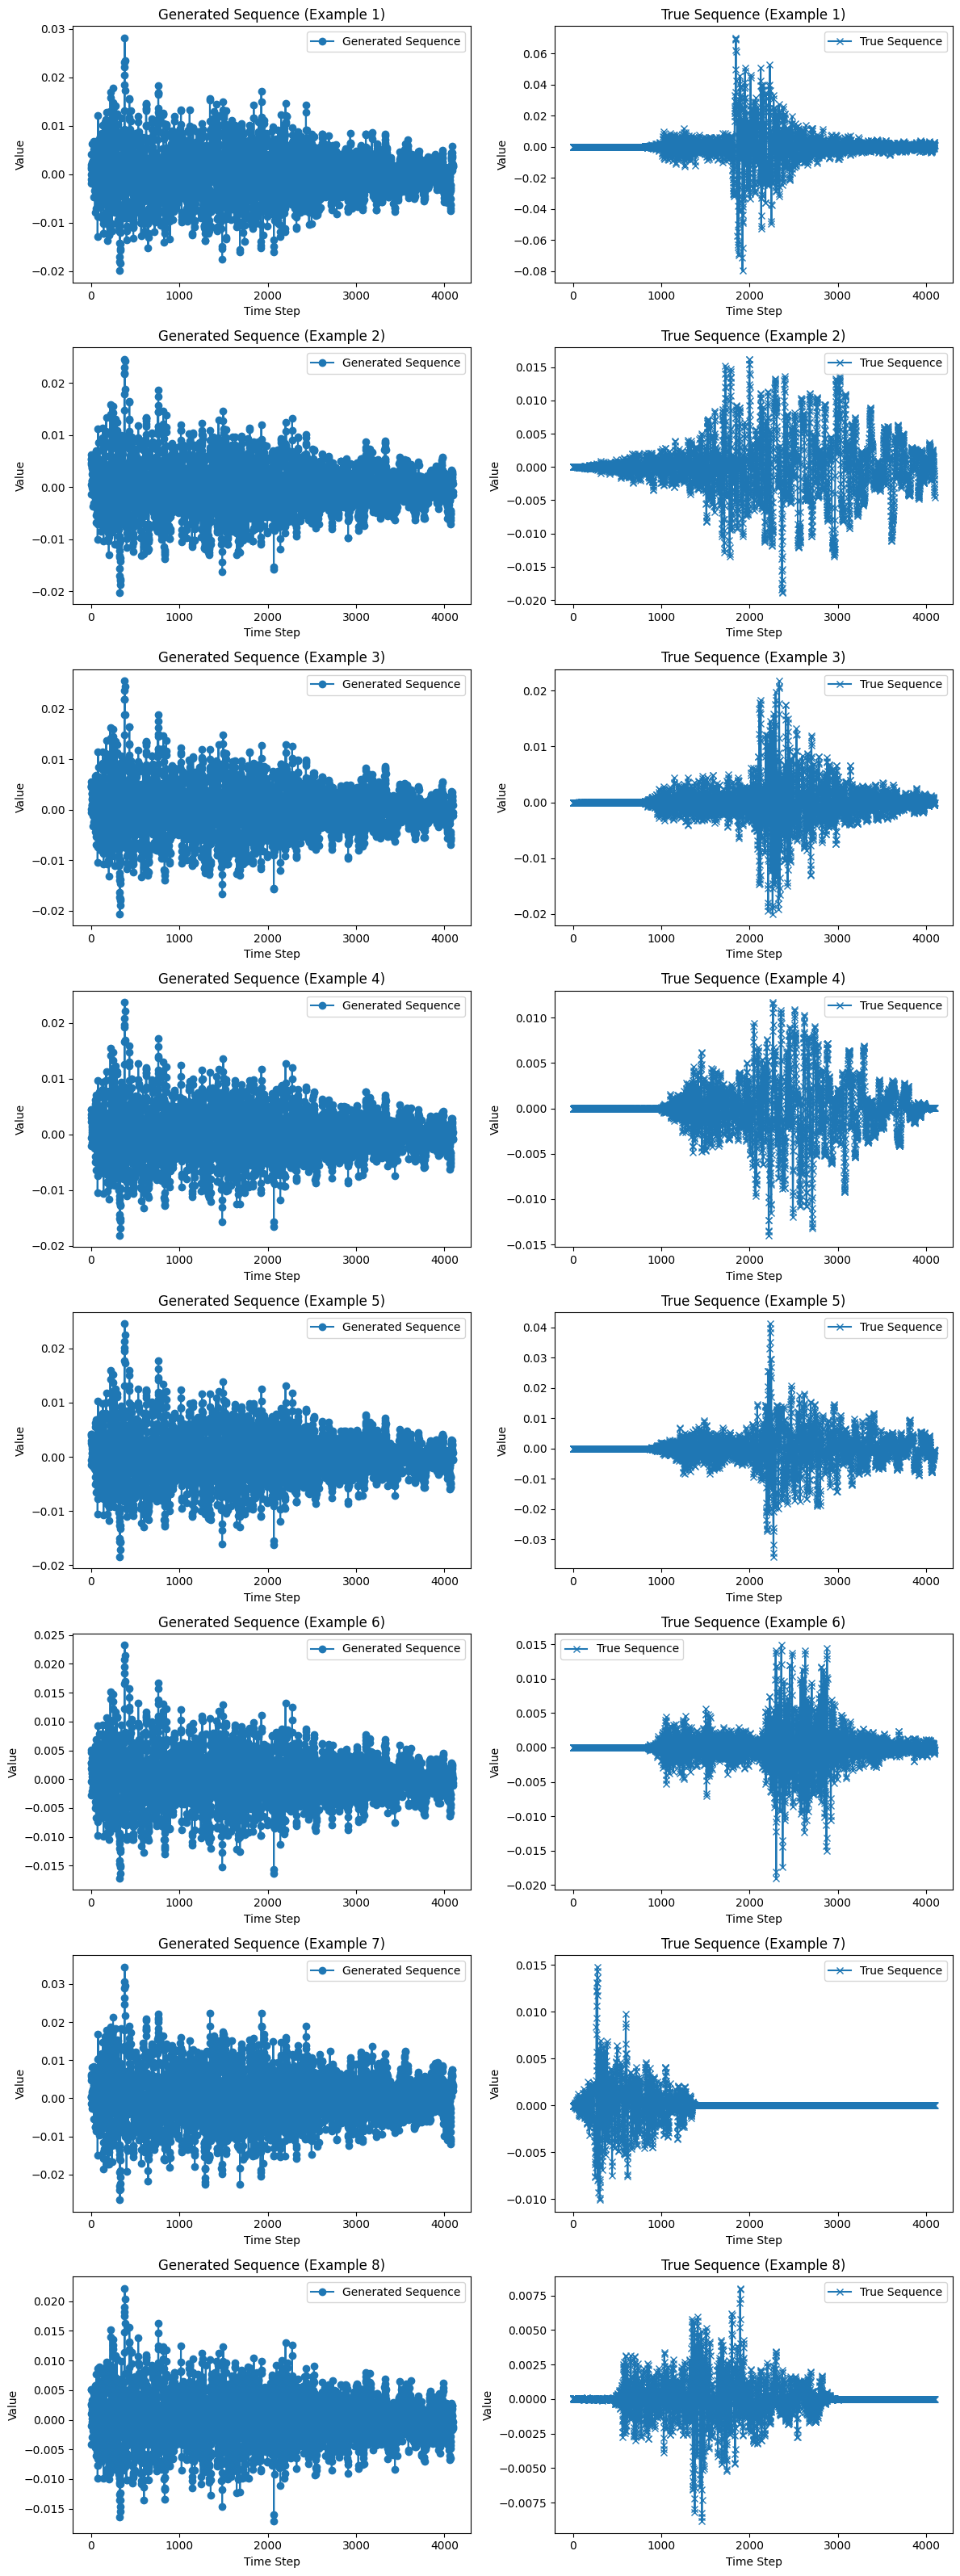

In [19]:
import matplotlib.pyplot as plt
%matplotlib inline

# Number of examples to plot
num_examples = 8

# Create a figure and subplots
fig, axes = plt.subplots(num_examples, 2, figsize=(12, 4 * num_examples))

# Iterate through the examples
for i in range(num_examples):
    # Select a random example from the test set
    example_index = np.random.randint(0, len(xTest))
    test_input = np.reshape(xTest[example_index, :], (1, 93))
    generated_sequence = model_attention.predict(test_input)

    # Plot the generated sequence
    axes[i, 0].plot(generated_sequence[0, 0, :], label='Generated Sequence', marker='o')
    axes[i, 0].set_title(f"Generated Sequence (Example {i+1})")
    axes[i, 0].set_xlabel("Time Step")
    axes[i, 0].set_ylabel("Value")
    axes[i, 0].legend()

    # Plot the true sequence
    axes[i, 1].plot(yTest[example_index, :], label='True Sequence', marker='x')
    axes[i, 1].set_title(f"True Sequence (Example {i+1})")
    axes[i, 1].set_xlabel("Time Step")
    axes[i, 1].set_ylabel("Value")
    axes[i, 1].legend()

# Adjust spacing between subplots
plt.tight_layout()
plt.show()